In [1]:
# Copyright 2023 The Cirq Developers
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gate with Registers

This package includes a subclass of `cirq.Gate` called `GateWithRegisters`. Instead of operating on a flat list of `cirq.Qid`, this lets the developer define gates in terms of named registers of given widths.

## [`Signature`](/reference/qualtran/Signature.md)

[`Register`](/reference/qualtran/Register.md) objects have a name, a bitsize and a shape. [`Signature`](/reference/qualtran/Signature.md) is an ordered collection of [`Register`](/reference/qualtran/Register.md) with some helpful methods.

In [2]:
from qualtran import Register, Signature, QAny

control_reg = Register('control', QAny(bitsize=2))
target_reg = Register('target', QAny(bitsize=3))
control_reg, target_reg

(Register(name='control', dtype=QAny(bitsize=2), shape=(), side=<Side.THRU: 3>),
 Register(name='target', dtype=QAny(bitsize=3), shape=(), side=<Side.THRU: 3>))

In [3]:
r = Signature([control_reg, target_reg])
r

Signature((Register(name='control', dtype=QAny(bitsize=2), shape=(), side=<Side.THRU: 3>), Register(name='target', dtype=QAny(bitsize=3), shape=(), side=<Side.THRU: 3>)))

You can also use the `build` factory method to quickly define a set of registers

In [4]:
r == Signature.build(
    control=2,
    target=3,
)

True

### `GateWithRegisters`

In [5]:
import cirq
from qualtran import GateWithRegisters

class MyGate(GateWithRegisters):
    
    @property
    def signature(self):
        return Signature.build(
            control=2,
            target=3,
        )
    
    def decompose_from_registers(self, context, control, target):
        assert len(control) == 2
        assert len(target) == 3
        
        for c in control:
            for t in target:
                yield cirq.CNOT(c, t)
        

In [6]:
gate = MyGate()
gate

In [7]:
# Number of qubits is derived from registers
cirq.num_qubits(gate)

5

The [`Signature`](/reference/qualtran/Signature.md) object can allocate a dictionary of `cirq.NamedQubit` that we can use to turn our `Gate` into an `Operation`. `GateWithRegisters` exposes an `on_registers` method to compliment Cirq's `on` method where we can use names to make sure each qubit is used appropriately.

In [8]:
from qualtran._infra.gate_with_registers import get_named_qubits

r = gate.signature
quregs = get_named_qubits(r)
quregs

{'control': array([cirq.NamedQubit('control0'), cirq.NamedQubit('control1')],
       dtype=object),
 'target': array([cirq.NamedQubit('target0'), cirq.NamedQubit('target1'),
        cirq.NamedQubit('target2')], dtype=object)}

In [9]:
operation = gate.on_registers(**quregs)
operation

<__main__.MyGate object at 0x7f2deed79a50>.on(cirq.NamedQubit('control0'), cirq.NamedQubit('control1'), cirq.NamedQubit('target0'), cirq.NamedQubit('target1'), cirq.NamedQubit('target2'))

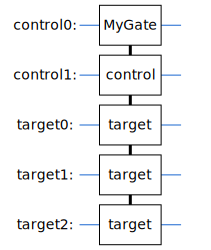

In [10]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(cirq.Circuit(operation))

## `GateHelper`

Since `GateWithRegisters` contains enough metadata to derive qubits, an operation, and a circuit we provide a helper class to provide easy access to these quantities.

In [11]:
import qualtran.cirq_interop.testing as cq_testing

g = cq_testing.GateHelper(gate)

print('r:', g.r)
print('quregs:', g.quregs)
print('operation:', g.operation)
print('\ncircuit:\n', g.circuit)
print('\n\ndecomposed circuit:\n', cirq.Circuit(cirq.decompose_once(g.operation)))

r: Signature((Register(name='control', dtype=QAny(bitsize=2), shape=(), side=<Side.THRU: 3>), Register(name='target', dtype=QAny(bitsize=3), shape=(), side=<Side.THRU: 3>)))
quregs: {'control': array([cirq.NamedQubit('control0'), cirq.NamedQubit('control1')],
      dtype=object), 'target': array([cirq.NamedQubit('target0'), cirq.NamedQubit('target1'),
       cirq.NamedQubit('target2')], dtype=object)}
operation: <__main__.MyGate object at 0x7f2deed79a50>(control0, control1, target0, target1, target2)

circuit:
 control0: ───MyGate────
             │
control1: ───control───
             │
target0: ────target────
             │
target1: ────target────
             │
target2: ────target────


decomposed circuit:
                  ┌──┐   ┌──┐
control0: ───@────@──────@─────────
             │    │      │
control1: ───┼────┼@─────┼@────@───
             │    ││     ││    │
target0: ────X────┼X─────┼┼────┼───
                  │      ││    │
target1: ─────────X──────┼X────┼───
              